In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.ndimage import gaussian_filter
from astropy.stats import sigma_clipped_stats
from scipy.stats import wilcoxon
import random
random.seed(46)

def binarize(image):
    out = np.copy(image)
    out[out>0]=1
    return out

In [25]:
def countZeroPixels(image):
    """Return the number of value-zero pixels in the image."""
    image=image.flatten()
    return len(image)-np.count_nonzero(image)

def getImageContrast(image):
    """Calculate a simple measure of the image contrast."""
    image=image.flatten()
    image = image[image>0]
    maxp = np.max(image)
    minp = np.min(image)
    return (maxp-minp)/(maxp+minp)

def npixelsAboveNoise(image,threshold=5):
    """Calculate the number pixels above X*sigma of the noise."""
    image=image.flatten()
    image=image[image>0]
    rmsnoise = np.sqrt(np.mean(image**2.))
    return len(image[np.where(image>threshold*rmsnoise)])

def meanSepBrightPixels(image,threshold=5):
    """Return the mean separation (in px) between bright pixels."""
    image=image.flatten()
    image=image[image>0]
    rmsnoise = np.sqrt(np.mean(image**2.))
    sel = np.where(image>threshold*rmsnoise)
    if len(sel[0])==0:
        return 300
    else:
        return (90000/len(image[sel]))**0.5

def medianBrightYPosition(image,threshold=10):
    """Compute the median y-value among bright pixels."""
    rmsnoise = np.sqrt(np.mean(image**2.))
    positions = np.where(image>threshold*rmsnoise)
    return np.median(positions[0])

def medianBrightXPosition(image, threshold=10):
    """Compute the median x-value among bright pixels."""
    rmsnoise = np.sqrt(np.mean(image**2.))
    positions = np.where(image>threshold*rmsnoise)
    return np.median(positions[1])

def lr_contrast(image):
    # left and right sections of image
    left = image[:, :150]
    right = image[:, 150:]
    return np.abs(getImageContrast(left)-getImageContrast(right))

def ud_contrast(image):
    # left and right sections of image
    up = image[150:, :]
    down = image[:150, :]
    return np.abs(getImageContrast(up)-getImageContrast(down))

def triangular_contrast1(image):
    # get upper, lower triangle
    upper = np.triu(image)
    lower = np.tril(image)
    return np.abs(getImageContrast(upper)-getImageContrast(lower))

def triangular_contrast2(image):
    # get upper, lower triangle
    upper = np.triu(np.fliplr(image))
    lower = np.tril(np.fliplr(image))
    return np.abs(getImageContrast(upper)-getImageContrast(lower))

def ud_difference(image, threshold=10):
    # left and right sections of image
    rmsnoise = np.sqrt(np.mean(image**2.))
    up = image[150:, :]
    down = image[:150, :]
    #return (np.sum(up.flatten())-np.sum(down.flatten()))
    n_bright_up = len(up[up>threshold*rmsnoise])
    n_bright_down = len(down[down>threshold*rmsnoise])
    return np.abs(n_bright_up-n_bright_down)

def lr_difference(image, threshold=10):
    # left and right sections of image
    rmsnoise = np.sqrt(np.mean(image**2.))
    left = image[:, :150]
    right = image[:, 150:]
    #return (np.sum(left.flatten())-np.sum(right.flatten()))
    n_bright_l = len(left[left>threshold*rmsnoise])
    n_bright_r = len(right[right>threshold*rmsnoise])
    return np.abs(n_bright_l-n_bright_r)

def tri_difference1(image,threshold=10):
    # get upper, lower triangle
    rmsnoise = np.sqrt(np.mean(image**2.))
    upper = np.triu(image)
    lower = np.tril(image)
    n_upper = len(upper[upper>threshold*rmsnoise])
    n_lower = len(lower[lower>threshold*rmsnoise])
    return np.abs(n_upper-n_lower)

def tri_difference2(image,threshold=10):
    # get upper, lower triangle
    rmsnoise = np.sqrt(np.mean(image**2.))
    upper = np.triu(np.fliplr(image))
    lower = np.tril(np.fliplr(image))
    n_upper = len(upper[upper>threshold*rmsnoise])
    n_lower = len(lower[lower>threshold*rmsnoise])
    return np.abs(n_upper-n_lower)

def lr_zero(image, threshold=10):
    # left and right sections of image
    left = image[:, :150]
    right = image[:, 150:]
    n_bright_l = len(left[left==0])
    n_bright_r = len(right[right==0])
    return np.abs(n_bright_l-n_bright_r)

def ud_zero(image, threshold=10):
    # left and right sections of image
    up = image[150:, :]
    down = image[:150, :]
    n_bright_up = len(up[up==0])
    n_bright_down = len(down[down==0])
    return np.abs(n_bright_up-n_bright_down)

def symmetry_lr(image, clipsigma=10):
    orig = np.copy(image)
    clippedmean, jk, jk = sigma_clipped_stats(image[image!=0], sigma=10, maxiters=2, cenfunc=np.mean)
    image[image>clipsigma*clippedmean] = clippedmean
    flipped = np.fliplr(image)
    diff = np.sum([image, -1*flipped], axis=0)
    return np.sqrt(np.mean(diff**2.))

def symmetry_ud(image, clipsigma=10):
    orig = np.copy(image)
    clippedmean, jk, jk = sigma_clipped_stats(image[image!=0], sigma=10, maxiters=2, cenfunc=np.mean)
    image[image>clipsigma*clippedmean] = clippedmean
    flipped = np.flipud(image)
    diff = np.sum([image, -1*flipped], axis=0)
    return np.sqrt(np.mean(diff**2.))

def symmetry_diag(image, clipsigma=10):
    orig = np.copy(image)
    clippedmean, jk, jk = sigma_clipped_stats(image[image!=0], sigma=10, maxiters=2, cenfunc=np.mean)
    image[image>clipsigma*clippedmean] = clippedmean
    flipped = image.T
    diff = np.sum([image, -1*flipped], axis=0)
    return np.sqrt(np.mean(diff**2.))

def moransI(x):
    w = np.zeros_like(x)+1
    xbar = np.median(x[x>0])
    top = np.sum(w*(x-xbar)*(x.T-xbar))
    bottom = np.sum((x-xbar)**2.)
    N = x.shape[0]*x.shape[1]
    return (N/np.sum(w))*top/bottom


def quadrant_sums(k):
    k = binarize(k)
    sums=[np.sum(k[0:150,0:150]), np.sum(k[0:150,150:300]), np.sum(k[150:300,0:150]), np.sum(k[150:300,150:300])]
    return (max(sums)-min(sums))/max(sums)

metadata_funcs = [symmetry_lr, symmetry_ud, symmetry_diag, ud_difference, lr_difference, moransI, countZeroPixels]#, lr_zero, ud_zero,\
                 #tri_difference1, tri_difference2, meanSepBrightPixels,\
                 # npixelsAboveNoise, getImageContrast,]
#metadata_funcs = [ud_difference, lr_difference, lr_zero, ud_zero, meanSepBrightPixels,\
#                  npixelsAboveNoise, getImageContrast, countZeroPixels, tri_difference1, tri_difference2]

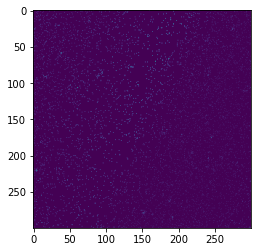

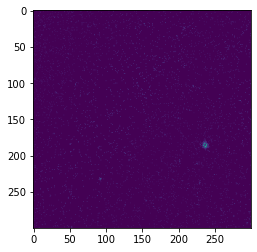

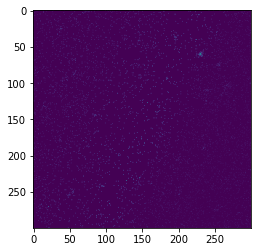

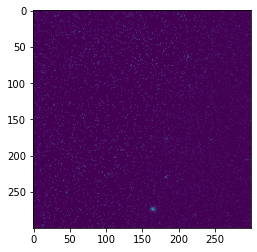

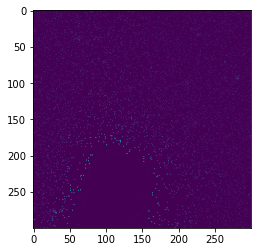

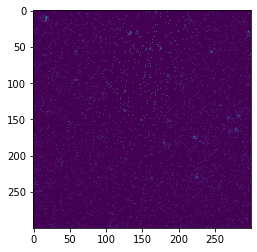

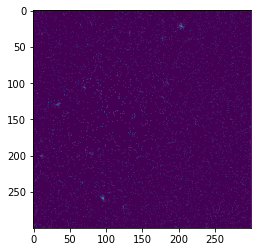

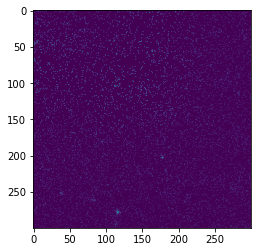

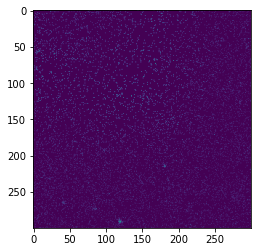

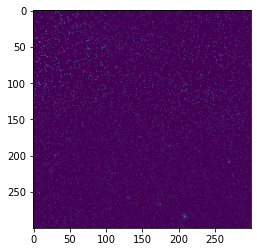

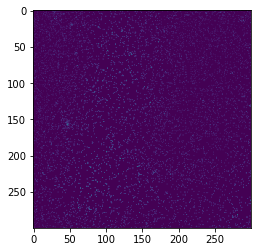

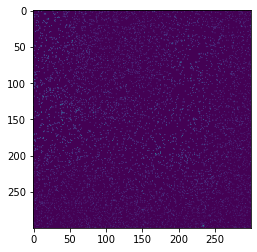

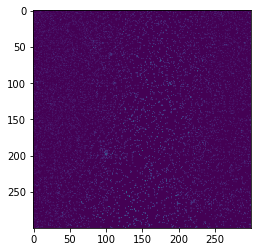

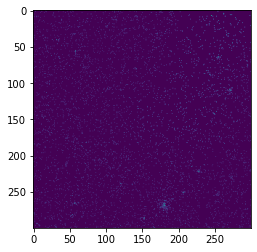

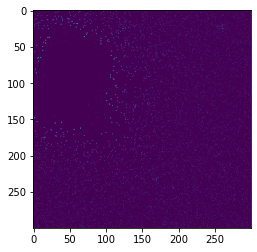

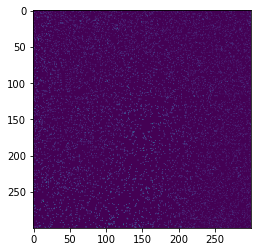

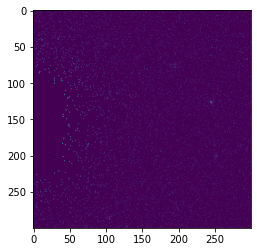

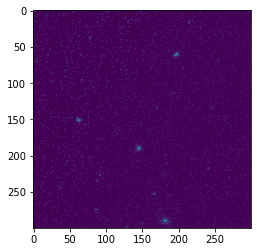

In [3]:
imagesXgood = []
labelsygood = []
imagesXpoor = []
labelsypoor = []
snrgood = []
snrpoor = []
qsumsgood = []
qsumspoor = []

goodcount=[]
dpath = "/srv/scratch/zhutchen/khess_images/detections/"
for f in os.listdir(dpath):
    if f.endswith('.fits'):
        #imagesX.append(np.array(fits.open(dpath+f)[0].data).flatten())
        image = fits.open(dpath+f)[0].data
        goodcount.append(countZeroPixels(image))
        imagesXgood.append(np.array([fx(image) for fx in metadata_funcs]))
        labelsygood.append('good_coverage')
        snrgood.append(np.mean(image)/np.std(image))
        qsumsgood.append(quadrant_sums(image))

ndpath = "/srv/scratch/zhutchen/khess_images/nondetections/"
for f in os.listdir(ndpath):
    if f.endswith('.fits'):
        #imagesX.append(np.array(fits.open(ndpath+f)[0].data).flatten())
        image = fits.open(ndpath+f)[0].data
        goodcount.append(countZeroPixels(image))
        imagesXgood.append(np.array([fx(image) for fx in metadata_funcs]))
        labelsygood.append('good_coverage')
        snrgood.append(np.mean(image)/np.std(image))
        qsumsgood.append(quadrant_sums(image))

i=0
testarray=[]
pcpath = "/srv/scratch/zhutchen/khess_images/poor_coverage/"
for f in os.listdir(pcpath):
    if f.endswith('.fits') and i>-1:
        #imagesX.append(np.array(fits.open(pcpath+f)[0].data).flatten()) #flatten each 300x300 image to 1x90000
        image = fits.open(pcpath+f)[0].data
        testarray.append(countZeroPixels(image))
        imagesXpoor.append(np.array([fx(image) for fx in metadata_funcs]))
        labelsypoor.append('poor_coverage')
        snrpoor.append(np.mean(image)/np.std(image))
        qsumspoor.append(quadrant_sums(image))
        i+=1
        if np.mean(image)/np.std(image)>0.2:# or countZeroPixels(image)<0.98*90000 or quadrant_sums(image)<0.3:
            plt.figure()
            plt.imshow((image))
            plt.show()

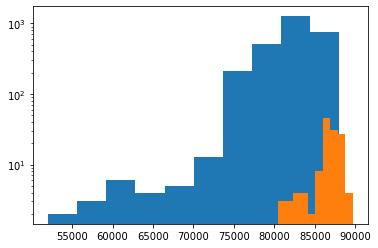

80454

In [4]:
plt.figure()
plt.hist(goodcount)
plt.hist(testarray)
plt.yscale('log')
plt.show()

min(testarray)

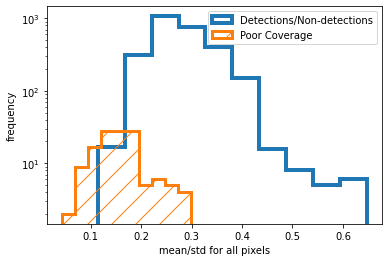

In [5]:
plt.figure()
plt.hist(snrgood, histtype='step', label='Detections/Non-detections', linewidth=4)
plt.hist(snrpoor, bins='fd', histtype='step', label='Poor Coverage', linewidth=3, hatch='/')
plt.yscale('log')
plt.xlabel("mean/std for all pixels")
plt.ylabel("frequency")
plt.legend(loc='best')
plt.show()

In [6]:
np.median(snrgood), np.median(snrpoor), np.max(snrpoor)

(0.2723354183986816, 0.15514958714005722, 0.29862374549519605)

In [7]:
snrpoor = np.array(snrpoor)
snrgood = np.array(snrgood)

sel = np.where(snrpoor<0.2)
print(len(snrpoor[sel])/len(snrpoor))

snrpoor = np.array(snrpoor)
snrgood = np.array(snrgood)

sel = np.where(snrgood<0.2)
print(len(snrgood[sel]), len(snrgood))

0.8636363636363636
143 2746


In [8]:
len(snrpoor),len(testarray)

(132, 132)

In [9]:
testarray=np.array(testarray)
sel = np.where(np.logical_or(snrpoor<0.2, testarray>0.98*90000))
print(len(testarray[sel])/132)

0.8636363636363636


# how to detect holes?
binarize image, invert it, then smooth on the size of hole you want to find, then run star finder.

In [32]:
from photutils import DAOStarFinder, CircularAperture

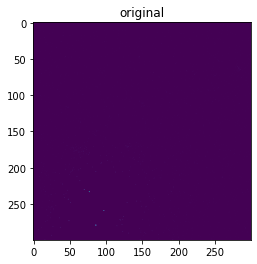

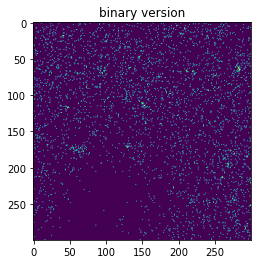

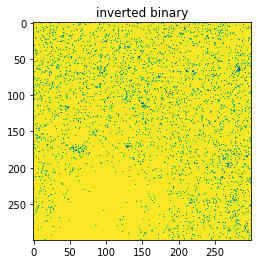

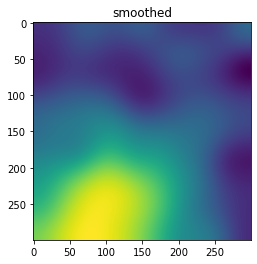

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,48.402428840837466,48.11767299907632,0.2873076603078409,-0.1993430264215888,-0.002858394837093108,16129,0.0,0.948635015859481,2.364405156894534,-0.934304744743636
2,250.68891179015503,47.920799974758836,0.28839446243869804,0.18367036419022356,-0.008617524939199116,16129,0.0,0.9513834431469882,2.3740263811780764,-0.9387138517701104
3,48.76339299518318,251.2512711281134,0.2876362031450858,0.17640833284734492,-0.022439379299312463,16129,0.0,0.9875992272330105,2.466656591071288,-0.9802717276116508
4,250.13685313925782,250.95925766063928,0.28725232874020656,-0.19283519425614604,-0.018443488617151334,16129,0.0,0.9532428945722314,2.3690513050066695,-0.9364361651458964


In [45]:
image = fits.open("/srv/scratch/zhutchen/khess_images/poor_coverage/RASS-Int_Hard_grp3543.0_.fits")
image = image[0].data

plt.figure()
plt.imshow(image)
plt.title("original")
plt.show()

plt.figure()
plt.imshow(binarize(image))
plt.title("binary version")
plt.show()

plt.figure()
invbi = 1-binarize(image)
plt.imshow(invbi)
plt.title("inverted binary")
plt.show()

plt.figure()
smoothed = gaussian_filter(invbi, 25)
plt.imshow(smoothed)
plt.title("smoothed")
plt.show()

daofind = DAOStarFinder(fwhm=100, threshold=10)
table = daofind.find_stars(smoothed)
table

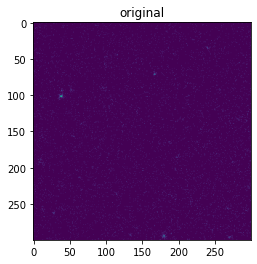

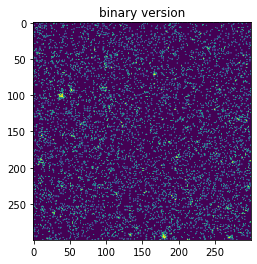

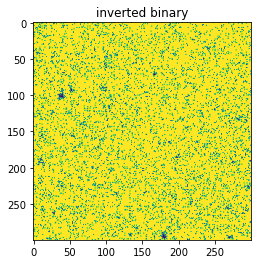

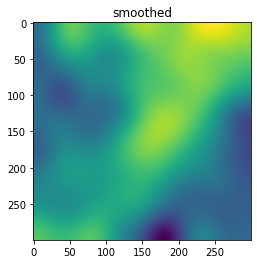

(41389.46186456339, 41621.53813543659)

In [42]:
image = fits.open("/srv/scratch/zhutchen/khess_images/nondetections/RASS-Int_Hard_grp10025.0_.fits")
image = image[0].data

plt.figure()
plt.imshow(image)
plt.title("original")
plt.show()

plt.figure()
plt.imshow(binarize(image))
plt.title("binary version")
plt.show()

plt.figure()
invbi = 1-binarize(image)
plt.imshow(invbi)
plt.title("inverted binary")
plt.show()

plt.figure()
smoothed = gaussian_filter(invbi, 25)
plt.imshow(smoothed)
plt.title("smoothed")
plt.show()

np.sum(smoothed[150:300,:]), np.sum(smoothed[0:150,:])